<a href="https://colab.research.google.com/github/custom-hyper/Analytics/blob/main/Screener_%E2%80%93_Basic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup Infra

Change Requests:
* Remove zeros of market capitalization
* Combine with other tables that don't often update but are useful for research

In [1]:
#@title Connect to FNS { display-mode: "code" }
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
#@title pip 
!pip install pytrends --quiet
!pip install pycoingecko --quiet
!pip install pandas --quiet
!pip install requests --quiet
!pip install pipreqs --quiet
!pip install configparser --quiet
!pip install psycopg2-binary==2.8.6 --quiet

!pip install matplotlib --quiet
!pip install mplfinance --quiet

     |████████████████████████████████| 3.0 MB 3.9 MB/s 
     |████████████████████████████████| 71 kB 3.1 MB/s 


In [3]:
#@title Ta-lib – Extra steps { display-mode: "code" }
!wget https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files/libta-lib0_0.4.0-oneiric1_amd64.deb -qO libta.deb
!wget https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files/ta-lib0-dev_0.4.0-oneiric1_amd64.deb -qO ta.deb
!dpkg -i libta.deb ta.deb
!pip install ta-lib

Selecting previously unselected package libta-lib0.
(Reading database ... 123991 files and directories currently installed.)
Preparing to unpack libta.deb ...
Unpacking libta-lib0 (0.4.0-oneiric1) ...
Selecting previously unselected package ta-lib0-dev.
Preparing to unpack ta.deb ...
Unpacking ta-lib0-dev (0.4.0-oneiric1) ...
Setting up libta-lib0 (0.4.0-oneiric1) ...
Setting up ta-lib0-dev (0.4.0-oneiric1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Processing triggers for libc-bin (2.27-3ubuntu1.6) ...
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 271 kB 4.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for ta-lib: filename=TA_Lib-0.4.25-cp37-cp37m-linux_x86_64.whl size=1471139 sha256=a651ec0ade3960eff80eb21fb343dd929ca6c8aeb9986309c13d

In [4]:
#@title Import Project  Dependencies { display-mode: "code" }
import requests
import mplfinance as fplt
from datetime import datetime as dt
from datetime import timedelta
from datetime import date
import talib as ta
import time
import json
import seaborn as sns
from google.colab import data_table
import plotly.graph_objects as go
import pandas as pd
import matplotlib.pyplot as plt
from pandas.io.json import json_normalize
import logging
import sys
from tqdm.notebook import tqdm
import os
import sqlite3 as sq
import psycopg2 as pg
import configparser
from sqlalchemy import create_engine
from pycoingecko import CoinGeckoAPI
import numpy as np
#from __future__ import division

## Setup SQLite


In [5]:
#@title  Connect { display-mode: "code" }
path = '/content/drive/MyDrive/workspace/pipelines/db/' #@param {type: 'string'
database = "db.sqlite" #@param {type: 'string'
conn_SQLite = sq.connect(path+database)

In [6]:
#@title   Show Available Tables { display-mode: "code" }
cursor = conn_SQLite.cursor()

%time
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
#cursor.execute("DROP TABLE 'proprietary_Twitter_Partnership_ohlc';")
cursor.fetchall()

CPU times: user 5 µs, sys: 1e+03 ns, total: 6 µs
Wall time: 10.7 µs


[('deFi_lama_total_TVL',),
 ('proprietary_Twitter_Partnership_ohlc',),
 ('proprietary_master_id',),
 ('CoinGecko_ohlc',),
 ('proprietary_tweets_extract',),
 ('proprietary_Twitter_partnerships_announcements',),
 ('proprietary_dashboard',),
 ('watchlist_CoinGecko_ohlc',),
 ('deFi_lama_tvl',),
 ('testing',),
 ('proprietary_airtable_watch_all',),
 ('deFi_lama_general',),
 ('proprietary_Twitter_id',),
 ('CoinGecko_main',),
 ('cal_mvp',),
 ('proprietary_economic_announcement',),
 ('ftx_subaccount_nickname',),
 ('ftx_subaccount_balances',),
 ('ftx_account',),
 ('ftx_positions',),
 ('ftx_wallet_coins',),
 ('ftx_wallet_deposits',),
 ('ftx_wallet_withdrawals',),
 ('ftx_orders_history',),
 ('ftx_fills',),
 ('ftx_funding_payments',),
 ('ftx_balancess',),
 ('ftx_markets',),
 ('ftx_futures',),
 ('CoinGecko_currencies',),
 ('CoinGecko_global',),
 ('CoinGecko_asset_platforms',),
 ('CoinGecko_categories',),
 ('CoinGecko_derivatives',),
 ('CoinGecko_derivatives_exchange_list',),
 ('proprietary_screener_

# Extract Data

Data source: [CoinGecko API wrapper](https://github.com/man-c/pycoingecko)

In [9]:
#@title Main – Extract { display-mode: "code" }

frames = []
cg = CoinGeckoAPI()

try:

  start =  1
  ends = 160

  for i in tqdm(range(start,ends)):

    output = cg.get_coins_markets(vs_currency='usd', page = i)
    
    data = pd.json_normalize(output,max_level=4)
    frames.append(data)
    time.sleep(10)

except ConnectionError:
    time.sleep(60)

full_table = pd.concat(frames) #Careful, this line must be outside of the for loop




In [10]:
full_table.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6700 entries, 0 to 99
Data columns (total 29 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                6700 non-null   object 
 1   symbol                            6700 non-null   object 
 2   name                              6700 non-null   object 
 3   image                             6700 non-null   object 
 4   current_price                     6699 non-null   float64
 5   market_cap                        6700 non-null   float64
 6   market_cap_rank                   3946 non-null   object 
 7   fully_diluted_valuation           3244 non-null   float64
 8   total_volume                      6700 non-null   float64
 9   high_24h                          5547 non-null   float64
 10  low_24h                           5547 non-null   float64
 11  price_change_24h                  5547 non-null   float64
 12  price_ch

In [12]:
#@title Main – Wrangling{ display-mode: "code" }
full_table['price_range_percent_24h'] =  (full_table['high_24h'] - full_table['low_24h'] ) / 0.5*(full_table['high_24h'] + full_table['low_24h'] ) 
full_table['circulating_cap'] = full_table['current_price'] * full_table['circulating_supply']
full_table['total_cap'] = full_table['current_price'] * full_table['total_supply']
full_table['max_cap'] = full_table['current_price'] * full_table['max_supply']
full_table['price_change_percentage_24h'] = full_table['price_change_percentage_24h']/100
full_table['ath_change_percentage'] = full_table['ath_change_percentage']/100
full_table['market_cap_change_percentage_24h'] = full_table['market_cap_change_percentage_24h']/100
full_table['atl_change_percentage'] = full_table['atl_change_percentage']/100
full_table['dilution_change_percentage_24h'] = full_table['market_cap_change_percentage_24h'] - full_table['price_change_percentage_24h']
full_table['prop_timestamp'] = int( time.time_ns() / 1000 )
full_table['prop_timestamp'] = full_table['prop_timestamp'].astype(np.int8)
full_table['CoinGecko_link'] = str('https://www.coingecko.com/en/coins/') + full_table['id']
full_table['symbol'] = full_table['symbol'].str.upper()
full_table['dilution_ratio'] = full_table['max_supply'] / full_table['circulating_supply']
full_table['float_rotation_24h'] = full_table['total_volume'] / full_table['market_cap']
full_table['price_change_percentage_24h']  = full_table['price_change_percentage_24h']:.7f

#Ranking
full_table['price_range_percent_24h_rank']  =  full_table['price_range_percent_24h'].rank(pct=True)
full_table['total_volume_rank_pct']  =  full_table['total_volume'].rank(pct=True)
full_table['dilution_change_percentage_24h_rank_pct'] = full_table['dilution_change_percentage_24h'].rank(pct=True)
full_table['circulating_cap_rank_pct'] = full_table['circulating_cap'].rank(pct=True)
full_table['total_cap_rank_pct'] = full_table['total_cap'].rank(pct=True)
full_table['max_cap_rank_pct'] = full_table['max_cap'].rank(pct=True)
full_table['price_change_percentage_24h_rank_pct'] = full_table['price_change_percentage_24h'].rank(pct=True)
full_table['market_cap_change_percentage_24h_rank_pct'] = full_table['market_cap_change_percentage_24h'].rank(pct=True)
full_table['market_cap_rank_pct'] = full_table['market_cap'].rank(pct=True)
full_table['dilution_ratio_rank_pct'] = full_table['dilution_ratio'].rank(pct=True)
full_table['float_rotation_24h_rank_pct'] = full_table['float_rotation_24h'].rank(pct=True)

#Date
full_table['date'] = date.today()

full_table.replace([np.inf, -np.inf], np.nan, inplace=True)
full_table


SyntaxError: ignored

In [14]:
full_table.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6700 entries, 0 to 99
Data columns (total 38 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                6700 non-null   object 
 1   symbol                            6700 non-null   object 
 2   name                              6700 non-null   object 
 3   image                             6700 non-null   object 
 4   current_price                     6699 non-null   float64
 5   market_cap                        6700 non-null   float64
 6   market_cap_rank                   3946 non-null   object 
 7   fully_diluted_valuation           3244 non-null   float64
 8   total_volume                      6700 non-null   float64
 9   high_24h                          5547 non-null   float64
 10  low_24h                           5547 non-null   float64
 11  price_change_24h                  5547 non-null   float64
 12  price_ch

In [17]:

proprietary_screener = "proprietary_screener"

full_table.to_sql(proprietary_screener, conn_SQLite, if_exists='replace', index=False) # writes to file
conn_SQLite.commit()

# Just be sure any changes have been committed or they will be lost.

main = pd.read_sql('select * from {} GROUP BY id'.format(proprietary_screener), conn_SQLite)

main.head()


,id,symbol,name,image,current_price,market_cap,market_cap_rank,fully_diluted_valuation,total_volume,high_24h,...,roi.percentage,price_range_percent_24h,circulating_cap,total_cap,max_cap,dilution_change_percentage_24h,prop_timestamp,CoinGecko_link,dilution_ratio,float_rotation_24h
0,0-5x-long-algorand-token,ALGOHALF,0.5X Long Algorand,https://assets.coingecko.com/coins/images/1200...,9427.01,0.0,None,NaN,0.37708,NaN,...,NaN,NaN,0.0,NaN,NaN,NaN,16,https://www.coingecko.com/en/coins/0-5x-long-a...,NaN,inf
1,0-5x-long-bitcoin-token,HALF,0.5X Long Bitcoin,https://assets.coingecko.com/coins/images/1199...,10470.20,0.0,None,NaN,104.70000,NaN,...,NaN,NaN,0.0,NaN,NaN,NaN,16,https://www.coingecko.com/en/coins/0-5x-long-b...,NaN,inf
2,0-5x-long-ethereum-classic-token,ETCHALF,0.5X Long Ethereum Classic,https://assets.coingecko.com/coins/images/1199...,20717.00,0.0,None,NaN,8577.87000,NaN,...,NaN,NaN,0.0,NaN,NaN,NaN,16,https://www.coingecko.com/en/coins/0-5x-long-e...,NaN,inf
3,0-5x-long-ethereum-token,ETHHALF,0.5X Long Ethereum,https://assets.coingecko.com/coins/images/1199...,21056.00,0.0,None,NaN,151.39000,NaN,...,NaN,NaN,0.0,NaN,NaN,NaN,16,https://www.coingecko.com/en/coins/0-5x-long-e...,NaN,inf
4,0-5x-long-matic-token,MATICHALF,0.5X Long Matic Token,https://assets.coingecko.com/coins/images/1199...,89069.00,0.0,None,NaN,1092.56000,NaN,...,NaN,NaN,0.0,NaN,NaN,NaN,16,https://www.coingecko.com/en/coins/0-5x-long-m...,NaN,inf


,id,name,market_cap,market_cap_change_24h,content,volume_24h,updated_at
0,wallets,Wallets,1.069397e+09,-4.319179,,1.213698e+08,2022-11-23T17:40:37.525Z
1,fan-token,Fan Token,3.005849e+08,-3.337922,None,8.830445e+07,2022-11-23T17:40:10.267Z
2,synths,Synths,8.077932e+07,-3.152898,None,1.632822e+07,2022-11-23T17:40:20.724Z
3,ohm-fork,Ohm Fork,7.061107e+07,-2.048474,,7.759938e+04,2022-11-23T17:40:18.325Z
4,algorand-ecosystem,Algorand Ecosystem,1.746776e+09,-1.551035,,1.102273e+08,2022-11-23T17:40:35.524Z
...,...,...,...,...,...,...,...
81,metagovernance,Metagovernance,3.522210e+08,10.587966,Metagovernance refers to projects or protocols...,1.822196e+07,2022-11-23T17:40:34.811Z
82,exchange-based-tokens,Exchange-based Tokens,7.091446e+10,12.744948,These tokens are normally associated with both...,3.360205e+09,2022-11-23T17:40:26.097Z
83,analytics,Analytics,5.469325e+08,12.953861,These projects provide advanced insights and c...,8.597044e+07,2022-11-23T17:40:23.194Z
84,centralized-exchange-token-cex,Centralized Exchange (CEX),6.199010e+10,13.521313,These utility tokens are issued by a centraliz...,2.214524e+09,2022-11-23T17:40:13.087Z


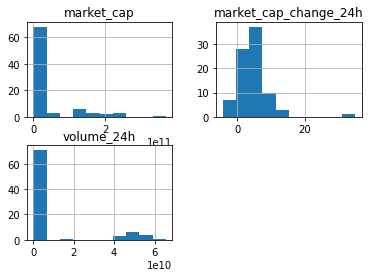

In [19]:
#@title Categories Data { display-mode: "code" }

cg = CoinGeckoAPI()
output = cg.get_coins_categories(include_tickers ='unexpired')
data = pd.json_normalize(output,max_level=4)
data = pd.DataFrame(output)
del data['top_3_coins']

CoinGecko_derivatives = "CoinGecko_categories"

data.to_sql(CoinGecko_derivatives, conn_SQLite, if_exists='replace', index=False) # writes to file
conn_SQLite.commit()

# Just be sure any changes have been committed or they will be lost.

CoinGecko_derivatives = pd.read_sql("""
select *
from {} 
Order by market_cap_change_24h	
""".format(CoinGecko_derivatives), conn_SQLite)

CoinGecko_derivatives.hist()
CoinGecko_derivatives




In [20]:
#@title Futures Product { display-mode: "code" }

cg = CoinGeckoAPI()
output = cg.get_derivatives(include_tickers ='unexpired')
data = pd.json_normalize(output,max_level=4)
data = pd.DataFrame(output, columns =(
    ['market', 'symbol', 'index_id', 'price', 'price_percentage_change_24h',
       'contract_type', 'index', 'basis', 'spread', 'funding_rate',
       'open_interest', 'volume_24h', 'last_traded_at', 'last_traded_at_f']))

data['last_traded_at_f'] = pd.to_datetime(data['last_traded_at'], unit='s')
CoinGecko_derivatives = "CoinGecko_derivatives"

data.to_sql(CoinGecko_derivatives, conn_SQLite, if_exists='replace', index=False) # writes to file
conn_SQLite.commit()

# Just be sure any changes have been committed or they will be lost.

CoinGecko_derivatives = pd.read_sql("""
select *
from {} 

""".format(CoinGecko_derivatives), conn_SQLite)

CoinGecko_derivatives.head()




,market,symbol,index_id,price,price_percentage_change_24h,contract_type,index,basis,spread,funding_rate,open_interest,volume_24h,last_traded_at,last_traded_at_f
0,Deepcoin (Derivatives),ETHUSDT,ETH,1154.25,2.945508,perpetual,1153.540000,0.016474,0.02,0.011382,3.228701e+09,5.106807e+08,1669225421,2022-11-23 17:43:41
1,Bitget Futures,BTCUSDT_UMCBL,BTC,16383.76,1.513554,perpetual,16359.471313,-0.033784,0.01,-0.010000,2.194781e+09,3.328328e+09,1669225345,2022-11-23 17:42:25
2,Binance (Futures),BTCUSDT,BTC,16376.56,1.473891,perpetual,16361.152211,0.018047,0.01,0.000787,2.073448e+09,8.024424e+09,1669225320,2022-11-23 17:42:00
3,BingX (Futures),BTC-USDT,BTC,16375.44,1.524223,perpetual,16362.720000,0.000000,0.01,-0.010000,1.485217e+09,2.827078e+09,1669225423,2022-11-23 17:43:43
4,Binance (Futures),ETHUSDT,ETH,1154.58,2.905249,perpetual,1153.251074,-0.003375,0.01,-0.005476,1.370176e+09,7.098809e+09,1669225319,2022-11-23 17:41:59


In [21]:
output = cg.get_derivatives_exchanges()
data = pd.json_normalize(output,max_level=4)
data = pd.DataFrame(output)

#@title Futures Exchanges { display-mode: "code" }

CoinGecko_derivatives = "CoinGecko_derivatives_exchange_list"

data.to_sql(CoinGecko_derivatives, conn_SQLite, if_exists='replace', index=False) # writes to file
conn_SQLite.commit()

# Just be sure any changes have been committed or they will be lost.

CoinGecko_derivatives = pd.read_sql("""
select *
from {} 

""".format(CoinGecko_derivatives), conn_SQLite)
CoinGecko_derivatives.head()

,name,id,open_interest_btc,trade_volume_24h_btc,number_of_perpetual_pairs,number_of_futures_pairs,image,year_established,country,description,url
0,Binance (Futures),binance_futures,419193.60,2257321.84,237,42,https://assets.coingecko.com/markets/images/46...,2019.0,None,,https://www.binance.com/
1,BTCEX (Futures),btcex_futures,256769.34,845370.88,84,0,https://assets.coingecko.com/markets/images/75...,NaN,None,,https://www.btcex.com/en-us/
2,BTCC Futures,btcc_futures,223966.44,572230.7,11,63,https://assets.coingecko.com/markets/images/84...,2011.0,None,,https://www.btcc.com/en-US/trade/
3,OKX (Futures),okex_swap,208951.77,548904.78,172,603,https://assets.coingecko.com/markets/images/37...,NaN,None,,https://www.okx.com/trade-futures
4,Bitget Futures,bitget_futures,207253.49,359924.44,108,0,https://assets.coingecko.com/markets/images/59...,NaN,None,,https://www.bitget.com/en/



Reusable scripts

Short
```
WHERE
market_cap > 100000000
AND
dilution_ratio > 6;
```
Long
```
WHERE
price_change_percentage_24h > '2.0e-01'
AND
float_rotation_24h >  0.2
AN
dilution_ratio <  5
```

In [46]:

#@title OHLC { display-mode: "code" }


proprietary_master_id  = "proprietary_screener"


main = pd.read_sql("""

SELECT

id,
market_cap,
circulating_cap,
total_cap,
max_cap,
dilution_ratio,
price_change_percentage_24h,
float_rotation_24h

FROM {}

WHERE
market_cap > 5000000
AND
price_change_percentage_24h > '2.0e-01'
AND
dilution_ratio <  5
;
""".format(proprietary_master_id), conn_SQLite)

main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           7 non-null      object 
 1   market_cap                   7 non-null      float64
 2   circulating_cap              7 non-null      float64
 3   total_cap                    7 non-null      float64
 4   max_cap                      7 non-null      float64
 5   dilution_ratio               7 non-null      float64
 6   price_change_percentage_24h  7 non-null      float64
 7   float_rotation_24h           7 non-null      float64
dtypes: float64(7), object(1)
memory usage: 576.0+ bytes


In [47]:
from talib.abstract import *

cg = CoinGeckoAPI()
CoinGecko_id = main['id']
frames = []

try:

  start = 1
  ends = 200
  
  for i in tqdm(CoinGecko_id[start:ends]):

    a = cg.get_coin_ohlc_by_id(id=i, vs_currency='usd', days = 'max')

    df = pd.DataFrame(data=a, columns = ['date','open','high', 'low', 'close'])

    df['datetime'] = pd.to_datetime(df['date'], unit='ms')
    df['id'] = str(i)
    df['sma10'] = SMA(df, timeperiod=10,price='close') # calculate on close prices by default
    df['sma20'] = SMA(df, timeperiod=20,price='close') # calculate on close prices by default
    df['sma50'] = SMA(df, timeperiod=50,price='close') # calculate on close prices by default
    df['sma100'] = SMA(df, timeperiod=100,price='close') # calculate on close prices by default
    df['sma200'] = SMA(df, timeperiod=200,price='close') # calculate on close prices by default
    df['atr'] = ATR(df, timeperiod=20) # calculate on close prices by default

    trace1 = {
    'x': df.datetime,
    'open': df.open,
    'close': df.close,
    'high': df.high,
    'low': df.low,
    'type': 'candlestick',
    'name': str(i).upper(),
    'showlegend': True
    }


    trace2 = {
        'x': df.datetime,
        'y': df.sma10,
        'type': 'scatter',
        'mode': 'lines',
        'line': {
            'width': 1,
            'color': 'yellow'
                },
        'name': 'SMA 10'
    }

    trace3 = {
        'x': df.datetime,
        'y': df.sma20,
        'type': 'scatter',
        'mode': 'lines',
        'line': {
            'width': 1,
            'color': 'orange'
        },
        'name': 'SMA 20'
    }
    trace4 = {
        'x': df.datetime,
        'y': df.sma50,
        'type': 'scatter',
        'mode': 'lines',
        'line': {
            'width': 1,
            'color': 'green'
                },
        'name': 'SMA 50'
    }

    trace5 = {
        'x': df.datetime,
        'y': df.sma100,
        'type': 'scatter',
        'mode': 'lines',
        'line': {
            'width': 1,
            'color': 'blue'
        },
        'name': 'SMA 100'
    }
    trace6 = {
        'x': df.datetime,
        'y': df.sma200,
        'type': 'scatter',
        'mode': 'lines',
        'line': {
            'width': 1,
            'color': 'purple'
        },
        'name': 'SMA 200'
    }

    data = [trace1, trace2, trace3,trace4,trace5,trace6]

    # Config graph layout
    layout = go.Layout({
        'title': {
            'text': str(i).upper().replace("-"," ") + ' Moving Averages',
            'font': {
                'size': 15
            }
        }
    })

              
      #CHARTING
    fig = go.Figure(data=data, layout=layout)
    fig.show()


    CoinGeckoAPI
    #time.sleep(60/50)
    frames.append(df)
    

except ConnectionError:
  time.sleep(60)

single = pd.concat(frames) #Careful, this line must be outside of the for loop
single['prop_timestamp'] = int( time.time_ns() / 1000 )

single['query_date'] = date.today()
fig.write_html("Moving Averages.html")

  0%|          | 0/6 [00:00<?, ?it/s]

In [52]:
single.tail()


,price,datetime,market_cap,volume,id,stdev_30d,volume_30d,rel_volume,float_rotation
date,,,,,,,,,
1668902400000,1.466690,2022-11-20 00:00:00,5.253547e+06,55497.984043,unidex,0.416677,1.383883e+06,0.040103,0.010564
1668988800000,1.370628,2022-11-21 00:00:00,4.907955e+06,29503.180343,unidex,0.401421,1.382875e+06,0.021335,0.006011
1669075200000,1.457510,2022-11-22 00:00:00,5.222940e+06,133381.477209,unidex,0.380902,1.386339e+06,0.096211,0.025538
1669161600000,1.633911,2022-11-23 00:00:00,5.915205e+06,109375.026687,unidex,0.364099,1.388033e+06,0.078799,0.018490
1669198639000,1.941820,2022-11-23 10:17:19,6.956717e+06,440782.310094,unidex,0.347596,1.401292e+06,0.314554,0.063361


In [53]:
proprietary_screener = "proprietary_screener_ohlc"

single.to_sql(proprietary_screener, conn_SQLite, if_exists='replace', index=False) # writes to file
conn_SQLite.commit()

# Just be sure any changes have been committed or they will be lost.

ohlc = pd.read_sql('select * from {} GROUP BY id'.format(proprietary_screener), conn_SQLite)

ohlc

,price,datetime,market_cap,volume,id,stdev_30d,volume_30d,rel_volume,float_rotation
0,0.133824,2022-11-23 15:34:07,7.643723e+07,2.224719e+07,acala,0.027830,2.270242e+06,9.799481,0.291052
1,0.049209,2022-11-23 17:02:43,2.645149e+07,3.322288e+03,bzx-protocol,0.016110,2.732254e+03,1.215951,0.000126
2,0.011249,2022-11-23 18:03:49,2.020824e+07,1.969384e+06,circuits-of-value,0.001423,8.335928e+05,2.362525,0.097455
3,0.013981,2022-11-23 15:16:02,3.041632e+07,1.238997e+06,saito,0.002821,1.131671e+06,1.094838,0.040735
4,0.002988,2022-11-23 14:26:27,7.494011e+06,7.199541e+04,sifchain,0.002367,1.213531e+05,0.593272,0.009607
5,1.941820,2022-11-23 10:17:19,6.956717e+06,4.407823e+05,unidex,0.347596,1.401292e+06,0.314554,0.063361


In [50]:
#@title Other Historical { display-mode: "code" }
from talib.abstract import *
import pandas as pd
import numpy as np

cg = CoinGeckoAPI()
CoinGecko_id = main['id']
frames = []


try:
  start = 1
  ends = 200
  for i in tqdm(CoinGecko_id[start:ends]):

    a = cg.get_coin_market_chart_by_id(id=i, vs_currency='usd', days = 'max')

    b = a['prices']
    df1 = pd.DataFrame(b, columns = ['date','price'])
    df1['datetime'] = pd.to_datetime(df1['date'], unit='ms')
    df1.set_index("date", inplace = True)

    c = a['market_caps']
    df2 = pd.DataFrame(c, columns = ['date','market_cap'])
    df2.set_index("date", inplace = True)

    d = a['total_volumes']
    df3 = pd.DataFrame(d, columns = ['date','volume'])   
    df3.set_index("date", inplace = True)

    result = pd.concat([df1, df2,df3], ignore_index=False,axis=1)

    result['id'] = i
    result['stdev_30d'] = result['price'].rolling(30).std()
    result['volume_30d'] = result['volume'].rolling(30).mean()
    result['rel_volume'] = result['volume'] / result['volume_30d'] 
    result['float_rotation'] = result['volume'] / result['market_cap'] 
    

    frames.append(result)
    time.sleep(60/50)
except ConnectionError:
    time.sleep(60)
single = pd.concat(frames) #Careful, this line must be outside of the for loop



single.tail()

  0%|          | 0/6 [00:00<?, ?it/s]

,price,datetime,market_cap,volume,id,stdev_30d,volume_30d,rel_volume,float_rotation
date,,,,,,,,,
1668902400000,1.466690,2022-11-20 00:00:00,5.253547e+06,55497.984043,unidex,0.416677,1.383883e+06,0.040103,0.010564
1668988800000,1.370628,2022-11-21 00:00:00,4.907955e+06,29503.180343,unidex,0.401421,1.382875e+06,0.021335,0.006011
1669075200000,1.457510,2022-11-22 00:00:00,5.222940e+06,133381.477209,unidex,0.380902,1.386339e+06,0.096211,0.025538
1669161600000,1.633911,2022-11-23 00:00:00,5.915205e+06,109375.026687,unidex,0.364099,1.388033e+06,0.078799,0.018490
1669198639000,1.941820,2022-11-23 10:17:19,6.956717e+06,440782.310094,unidex,0.347596,1.401292e+06,0.314554,0.063361


In [51]:
from numpy.lib.twodim_base import histogram2d

proprietary_screener = "proprietary_screener_hist"

single.to_sql(proprietary_screener, conn_SQLite, if_exists='replace', index=True) # writes to file
conn_SQLite.commit()

# Just be sure any changes have been committed or they will be lost. WHERE datetime CONTAINS '2021'

hist = pd.read_sql("""
select 
*
from {}  

Group by id


""".format(proprietary_screener), conn_SQLite)

hist

,date,price,datetime,market_cap,volume,id,stdev_30d,volume_30d,rel_volume,float_rotation
0,1669217647000,0.133824,2022-11-23 15:34:07,7.643723e+07,2.224719e+07,acala,0.027830,2.270242e+06,9.799481,0.291052
1,1669222963000,0.049209,2022-11-23 17:02:43,2.645149e+07,3.322288e+03,bzx-protocol,0.016110,2.732254e+03,1.215951,0.000126
2,1669226629000,0.011249,2022-11-23 18:03:49,2.020824e+07,1.969384e+06,circuits-of-value,0.001423,8.335928e+05,2.362525,0.097455
3,1669216562000,0.013981,2022-11-23 15:16:02,3.041632e+07,1.238997e+06,saito,0.002821,1.131671e+06,1.094838,0.040735
4,1669213587000,0.002988,2022-11-23 14:26:27,7.494011e+06,7.199541e+04,sifchain,0.002367,1.213531e+05,0.593272,0.009607
5,1669198639000,1.941820,2022-11-23 10:17:19,6.956717e+06,4.407823e+05,unidex,0.347596,1.401292e+06,0.314554,0.063361


In [ ]:


ohlc  = ohlc[['datetime'] >  date.today()]
hist  = hist[['datetime'] = date.today()]

main.set_index("id", inplace = True)
ohlc.set_index("id", inplace = True)
hist.set_index("id", inplace = True)

full_table['date'] = date.today()

result = pd.concat([main,ohlc,hist])
result

Get CoinGecko Market Data

# Futures Coverage Indicator

In [ ]:
#Query the derivatives table

# Group table By index ID and create a: where if the  contract type includes perpetual, at P Contract type Futures exist, at letter



In [ ]:
proprietary_screener.head()

In [ ]:
proprietary_screener.info()

In [ ]:
#@title Gets Currencies { display-mode: "code" }
output = cg.get_supported_vs_currencies()
data = pd.DataFrame(output, columns =['currencies'])
CoinGecko_currencies = "CoinGecko_currencies"



data.to_sql(CoinGecko_currencies, conn_SQLite, if_exists='replace', index=False) # writes to file
conn_SQLite.commit()

# Just be sure any changes have been committed or they will be lost.

CoinGecko_currencies = pd.read_sql('select * from {}'.format(CoinGecko_currencies), conn_SQLite)

In [ ]:
#@title
output = cg.get_derivatives()
data = pd.json_normalize(output,max_level=4)
data

In [ ]:
#@title Get Global Data { display-mode: "code" }

output = cg.get_global()
data = pd.json_normalize(output,max_level=4)
data = pd.DataFrame(output)

CoinGecko_global = "CoinGecko_global"

data.to_sql(CoinGecko_global, conn_SQLite, if_exists='replace', index=False) # writes to file
conn_SQLite.commit()

# Just be sure any changes have been committed or they will be lost.

CoinGecko_global = pd.read_sql('select * from {}'.format(CoinGecko_global), conn_SQLite)
CoinGecko_global.info()

In [ ]:
#@title Get Assess platforms { display-mode: "code" }

output = cg.get_asset_platforms()

data = pd.json_normalize(output,max_level=4)
data = pd.DataFrame(output)



CoinGecko_asset_platforms = "CoinGecko_asset_platforms"

data.to_sql(CoinGecko_asset_platforms, conn_SQLite, if_exists='replace', index=False) # writes to file
conn_SQLite.commit()

# Just be sure any changes have been committed or they will be lost.

CoinGecko_asset_platforms = pd.read_sql('select * from {}'.format(CoinGecko_asset_platforms), conn_SQLite)
CoinGecko_asset_platforms.info()

**bold text**# Create Features

In [ ]:
#@title
# Just be sure any changes have been committed or they will be lost.
conn_SQLite.close()

# Backtesting

# Chartbook
